# Tutorial on Multimodal NLP with TensorFlow Hub and Keras
https://keras.io/examples/nlp/multimodal_entailment/

In [1]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import tensorflow as tf
import tensorflow_hub as hub
# import tensorflow_text as tf_text
from tensorflow import keras

## Dataset Creation

In [2]:
# Define label map
label_map = {"Contradictory": 0, "Implies": 1, "NoEntailment": 2}

In [3]:
# Collect the Dataset
image_base_path = keras.utils.get_file(
    "tweet_images",
    "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/releases/download/v1.0.0/tweet_images.tar.gz",
    untar=True,
)

In [4]:
# Read the dataset and apply basic preprocessing
df = pd.read_csv(
    "https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/csvs/tweets.csv"
)
df.sample(10)

,id_1,text_1,image_1,id_2,text_2,image_2,label
260,1348961143797252102,We offer Comprehensive Urological Care at Mukh...,http://pbs.twimg.com/media/Erh5ATBW8AAFqW9.jpg,1351254022473322499,We offer Comprehensive Urological Care at MASH...,http://pbs.twimg.com/media/EsCeXm5W8AEwRQV.jpg,NoEntailment
876,1357264688896172034,US Dollar is gathering strength as the new adm...,http://pbs.twimg.com/media/EtX5CscWYAE25_R.png,1368861886817697792,GBPUSD trading within a 1.38 channel and looki...,http://pbs.twimg.com/media/Ev8socuXEAUwRx1.png,NoEntailment
63,1336604171110375426,"Monet, La Pie. Musée d’Orsay, Paris. I’d quite...",http://pbs.twimg.com/media/EoySaELWMAAlMsC.jpg,1350048937575641090,La Pie (the Magpie)\nClaude Monet\n1868-1869\n...,http://pbs.twimg.com/media/ErxWWb2XUAAL3dK.jpg,NoEntailment
1216,1334917337414242306,This is how I'm expecting results to fall at t...,http://pbs.twimg.com/media/EoaTnncWMAEoMrw.jpg,1367893945733234692,This is how I'm expecting results to fall at t...,http://pbs.twimg.com/media/Evu8S0SXIAYXR7C.jpg,NoEntailment
1148,1367741500772159489,#India's #COVID19 recovery rate improves to 97...,http://pbs.twimg.com/media/EvsxlYlVIAEnSxS.png,1368087604428611589,#India's #COVID19 recovery rate improves to 96...,http://pbs.twimg.com/media/Evxsau4UcAAFXHe.png,NoEntailment
73,1375553221083729923,🔥 Not A Knife 🔥 Our newest knife of the month ...,http://pbs.twimg.com/media/ExbyXG4WEAEoWe8.jpg,1377365124697088003,🔥 Not A Knife 🔥 Our newest knife of the month ...,http://pbs.twimg.com/media/Ex1iR2gXAAohJeQ.jpg,Implies
227,1378061973141684224,"Friends, interested all go to have a look!\n@b...",http://pbs.twimg.com/media/Ex_cD9CVIAgxiLn.jpg,1381023285639479297,Friends! Anyone interested? Go and have a look...,http://pbs.twimg.com/media/EyphXCLUcAMdKgr.jpg,Contradictory
564,1382417876850724876,Inside tomorrow's Racing Post 📰 \n\n🏇 Coolmore...,http://pbs.twimg.com/media/Ey9VIKeWUAc_bcf.jpg,1383510579717935108,🗞️In tomorrow's Racing Post \n\n🏴󠁧󠁢󠁳󠁣󠁴󠁿Preview...,http://pbs.twimg.com/media/EzMsMEFVcAASG28.jpg,NoEntailment
1009,1354736292672794626,"Fortinet announces #FortiXDR, a new #AI-powere...",http://pbs.twimg.com/media/Esz9emKXUAIes_2.jpg,1357764912907497476,"Fortinet announces #FortiXDR, a new #AI-powere...",http://pbs.twimg.com/media/Ete__egWQAIiYzP.png,NoEntailment
1332,1378332774709538816,Good Saturday morning! Here are the temperatur...,http://pbs.twimg.com/media/EyDSV9QWgAUPea-.jpg,1383406386877407242,Good Saturday morning! Here are the temperatur...,http://pbs.twimg.com/media/EzLYu9PVUAs2nvu.jpg,NoEntailment


The columns we are interested in are the following:
<ul><font color=#00ff00>
<li>text_1
<li>image_1
<li>text_2
<li>image_2
<li>label
</ul></font>

The entailment task is formulated as the following:
<br>
<p>
Given the pairs of (<font color=#00ff00>text_1, image_1</font>) and (<font color=#00ff00>text_2, image_2</font>) do they entail (or not entail or contradict) each other?
<br>
<p>
We have the images already downloaded. <font color=#00ff00>image_1</font> is downloaded as <font color=#00ff00>id1</font> as its filename and <font color=#00ff00>image2</font> is downloaded as <font color=#00ff00>id2</font> as its filename. In the next step, we will add two more columns to df - filepaths of <font color=#00ff00>image_1</font>s and <font color=#00ff00>image_2</font>s.

In [5]:
images_one_paths = []
images_two_paths = []

for idx in range(len(df)):
    current_row = df.iloc[idx]

    # Get file format and image IDs
    id_1 = current_row["id_1"]
    id_2 = current_row["id_2"]
    extentsion_one = current_row["image_1"].split(".")[-1]
    extentsion_two = current_row["image_2"].split(".")[-1]

    # Create image paths
    image_one_path = os.path.join(image_base_path, str(id_1) + f".{extentsion_one}")
    image_two_path = os.path.join(image_base_path, str(id_2) + f".{extentsion_two}")

    # Append image paths to the lists
    images_one_paths.append(image_one_path)
    images_two_paths.append(image_two_path)

df["image_1_path"] = images_one_paths
df["image_2_path"] = images_two_paths

# Create another column with the label index for each label
df["label_idx"] = df["label"].apply(lambda x: label_map[x])


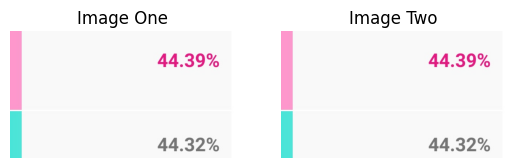

Text one: STOP WHATEVER YOU'RE DOING OUR GAP IS 0.07%❗❗❗❗

#FEVER_Part_2 #불놀이야 #Fireworks #ATEEZ #에이티즈 @ATEEZofficial https://t.co/0ONJYm1Wz8
Text two: EVERYONE FOCUS UP AND GET THIS DONE. WIDEN! THIS! GAP!!!! 

#FEVER_Part_2 #불놀이야 #Fireworks #ATEEZ #에이티즈 @ATEEZofficial https://t.co/jdOew2zjFD
Label: NoEntailment


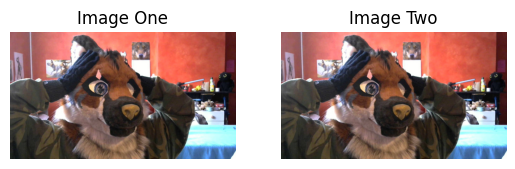

Text one: oh noes all the cookies are gone!

happy #FursuitFriday ! #fursuit #fursuiter https://t.co/eh8hIb36dn
Text two: So many cuties this #FursuitFriday I had to join in. https://t.co/bxOqzo498M
Label: NoEntailment


In [15]:
# Dataset Visualization
def visualize(idx):
    current_row = df.iloc[idx]
    image_1 = plt.imread(current_row["image_1_path"])
    image_2 = plt.imread(current_row["image_2_path"])
    text_1 = current_row["text_1"]
    text_2 = current_row["text_2"]
    label = current_row["label"]

    plt.subplot(1, 2, 1)
    plt.imshow(image_1)
    plt.axis("off")
    plt.title("Image One")
    plt.subplot(1, 2, 2)
    plt.imshow(image_1)
    plt.axis("off")
    plt.title("Image Two")
    plt.show()

    print(f"Text one: {text_1}")
    print(f"Text two: {text_2}")
    print(f"Label: {label}")


random_idx = np.random.choice(len(df))
visualize(random_idx)

random_idx = np.random.choice(len(df))
visualize(random_idx)

## Train/Test Split

The dataset suffers from <font color="00ff00">class imbalance problem</font>. We can confirm that in the following cell.

In [17]:
# Train / Test Split
df["label"].value_counts()

label
NoEntailment     1182
Implies           109
Contradictory     109
Name: count, dtype: int64

To account for that we will go for a stratified split.

In [18]:
# 10% for test
train_df, test_df = train_test_split(
    df, test_size=0.1, stratify=df["label"].values, random_state=42
)
# 5% for validation
train_df, val_df = train_test_split(
    train_df, test_size=0.05, stratify=train_df["label"].values, random_state=42
)

print(f"Total training examples: {len(train_df)}")
print(f"Total validation examples: {len(val_df)}")
print(f"Total test examples: {len(test_df)}")

Total training examples: 1197
Total validation examples: 63
Total test examples: 140


## Data Input Pipeline

TensorFlow Hub provides <font color="00ff00">variety of BERT family of models</font>. Each of those models comes with a corresponding preprocessing layer. You can learn more about these models and their preprocessing layers from <font color="00ff00"><a href="https://www.tensorflow.org/text/tutorials/bert_glue#loading_models_from_tensorflow_hub">this resource</a></font>.

To keep the runtime of this example relatively short, we will use a smaller variant of the original BERT model.

In [19]:
# Define TF Hub paths to the BERT encoder and its preprocessor
bert_model_path = (
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1"
)
bert_preprocess_path = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

Our text preprocessing code mostly comes from <a href="https://www.tensorflow.org/text/tutorials/bert_glue">this tutorial</a>. You are highly encouraged to check out the tutorial to learn more about the input preprocessing.

In [23]:
def make_bert_preprocessing_model(sentence_features, seq_length=128):
    """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: A list with the names of string-valued features.
    seq_length: An integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

    input_segments = [
        tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
        for ft in sentence_features
    ]

    # Tokenize the text to word pieces.
    bert_preprocess = hub.load(bert_preprocess_path)
    tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name="tokenizer")
    segments = [tokenizer(s) for s in input_segments]

    # Optional: Trim segments in a smart way to fit seq_length.
    # Simple cases (like this example) can skip this step and let
    # the next step apply a default truncation to approximately equal lengths.
    truncated_segments = segments

    # Pack inputs. The details (start/end token ids, dict of output tensors)
    # are model-dependent, so this gets loaded from the SavedModel.
    packer = hub.KerasLayer(
        bert_preprocess.bert_pack_inputs,
        arguments=dict(seq_length=seq_length),
        name="packer",
    )
    model_inputs = packer(truncated_segments)
    return keras.Model(input_segments, model_inputs)


bert_preprocess_model = make_bert_preprocessing_model(["text_1", "text_2"])
keras.utils.plot_model(bert_preprocess_model, show_shapes=True, show_dtype=True)

RuntimeError: Op type not registered 'CaseFoldUTF8' in binary running on Viniciuss-MacBook-Pro.local. Make sure the Op and Kernel are registered in the binary running in this process. Note that if you are loading a saved graph which used ops from tf.contrib, accessing (e.g.) `tf.contrib.resampler` should be done before importing the graph, as contrib ops are lazily registered when the module is first accessed.

<image href="https://keras.io/img/examples/nlp/multimodal_entailment/multimodal_entailment_22_0.png">Image 1</image>

### Run the preprocessor on a sample input

In [22]:
idx = np.random.choice(len(train_df))
row = train_df.iloc[idx]
sample_text_1, sample_text_2 = row["text_1"], row["text_2"]
print(f"Text 1: {sample_text_1}")
print(f"Text 2: {sample_text_2}")

test_text = [np.array([sample_text_1]), np.array([sample_text_2])]
text_preprocessed = bert_preprocess_model(test_text)

print("Keys           : ", list(text_preprocessed.keys()))
print("Shape Word Ids : ", text_preprocessed["input_word_ids"].shape)
print("Word Ids       : ", text_preprocessed["input_word_ids"][0, :16])
print("Shape Mask     : ", text_preprocessed["input_mask"].shape)
print("Input Mask     : ", text_preprocessed["input_mask"][0, :16])
print("Shape Type Ids : ", text_preprocessed["input_type_ids"].shape)
print("Type Ids       : ", text_preprocessed["input_type_ids"][0, :16])

Text 1: On 08/01/2021 at 07:00(AEST) the storage level was 295.02mAHD. https://t.co/h98aF82Ift
Text 2: On 21/02/2021 at 12:00(AEST) the storage level was 92.12mAHD. https://t.co/ugOaKh8WA1


NameError: name 'bert_preprocess_model' is not defined

We will now create <font color=00ff00>tf.data.Dataset</font> objects from the dataframes.

Note that the text inputs will be preprocessed as a part of the data input pipeline. But the preprocessing modules can also be a part of their corresponding BERT models. This helps reduce the training/serving skew and lets our models operate with raw text inputs. Follow <font color="00ff00"><a href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert">this tutorial</font></a> to learn more about how to incorporate the preprocessing modules directly inside the models.

In [ ]:
def dataframe_to_dataset(dataframe):
    columns = ["image_1_path", "image_2_path", "text_1", "text_2", "label_idx"]
    dataframe = dataframe[columns].copy()
    labels = dataframe.pop("label_idx")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds

### Preprocessing utilities

In [ ]:
resize = (128, 128)
bert_input_features = ["input_word_ids", "input_type_ids", "input_mask"]


def preprocess_image(image_path):
    extension = tf.strings.split(image_path)[-1]

    image = tf.io.read_file(image_path)
    if extension == b"jpg":
        image = tf.image.decode_jpeg(image, 3)
    else:
        image = tf.image.decode_png(image, 3)
    image = tf.image.resize(image, resize)
    return image


def preprocess_text(text_1, text_2):
    text_1 = tf.convert_to_tensor([text_1])
    text_2 = tf.convert_to_tensor([text_2])
    output = bert_preprocess_model([text_1, text_2])
    output = {feature: tf.squeeze(output[feature]) for feature in bert_input_features}
    return output


def preprocess_text_and_image(sample):
    image_1 = preprocess_image(sample["image_1_path"])
    image_2 = preprocess_image(sample["image_2_path"])
    text = preprocess_text(sample["text_1"], sample["text_2"])
    return {"image_1": image_1, "image_2": image_2, "text": text}

### Create the final datasets

In [ ]:
batch_size = 32
auto = tf.data.AUTOTUNE


def prepare_dataset(dataframe, training=True):
    ds = dataframe_to_dataset(dataframe)
    if training:
        ds = ds.shuffle(len(train_df))
    ds = ds.map(lambda x, y: (preprocess_text_and_image(x), y)).cache()
    ds = ds.batch(batch_size).prefetch(auto)
    return ds


train_ds = prepare_dataset(train_df)
validation_ds = prepare_dataset(val_df, False)
test_ds = prepare_dataset(test_df, False)

## Model Building Utilities

Our final model will accept two images along with their text counterparts. While the images will be directly fed to the model the text inputs will first be preprocessed and then will make it into the model. Below is a visual illustration of this approach:

<img href="https://github.com/sayakpaul/Multimodal-Entailment-Baseline/raw/main/figures/brief_architecture.png"></img>

The model consists of the following elements:

A standalone encoder for the images. We will use a <a href="https://arxiv.org/abs/1603.05027"> ResNet50V2 </a> pre-trained on the ImageNet-1k dataset for this.
A standalone encoder for the images. A pre-trained BERT will be used for this.
After extracting the individual embeddings, they will be projected in an identical space. Finally, their projections will be concatenated and be fed to the final classification layer.

This is a multi-class classification problem involving the following classes:

NoEntailment
Implies
Contradictory
<p> <font color=00ff00>project_embeddings()</font>, <font color=00ff00>create_vision_encoder()</font>, and <font color=00ff00>create_text_encoder()</font> utilities are referred from <a href="https://keras.io/examples/nlp/nl_image_search/">this example</a>.

#### Projection utilities

In [ ]:
def project_embeddings(
    embeddings, num_projection_layers, projection_dims, dropout_rate
):
    projected_embeddings = keras.layers.Dense(units=projection_dims)(embeddings)
    for _ in range(num_projection_layers):
        x = tf.nn.gelu(projected_embeddings)
        x = keras.layers.Dense(projection_dims)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
        x = keras.layers.Add()([projected_embeddings, x])
        projected_embeddings = keras.layers.LayerNormalization()(x)
    return projected_embeddings

#### Vision Encoder Utilities

In [ ]:
def create_vision_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained ResNet50V2 model to be used as the base encoder.
    resnet_v2 = keras.applications.ResNet50V2(
        include_top=False, weights="imagenet", pooling="avg"
    )
    # Set the trainability of the base encoder.
    for layer in resnet_v2.layers:
        layer.trainable = trainable

    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")

    # Preprocess the input image.
    preprocessed_1 = keras.applications.resnet_v2.preprocess_input(image_1)
    preprocessed_2 = keras.applications.resnet_v2.preprocess_input(image_2)

    # Generate the embeddings for the images using the resnet_v2 model
    # concatenate them.
    embeddings_1 = resnet_v2(preprocessed_1)
    embeddings_2 = resnet_v2(preprocessed_2)
    embeddings = keras.layers.Concatenate()([embeddings_1, embeddings_2])

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the vision encoder model.
    return keras.Model([image_1, image_2], outputs, name="vision_encoder")

#### Text Encoder Utilities

In [ ]:
def create_text_encoder(
    num_projection_layers, projection_dims, dropout_rate, trainable=False
):
    # Load the pre-trained BERT model to be used as the base encoder.
    bert = hub.KerasLayer(bert_model_path, name="bert",)
    # Set the trainability of the base encoder.
    bert.trainable = trainable

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Generate embeddings for the preprocessed text using the BERT model.
    embeddings = bert(inputs)["pooled_output"]

    # Project the embeddings produced by the model.
    outputs = project_embeddings(
        embeddings, num_projection_layers, projection_dims, dropout_rate
    )
    # Create the text encoder model.
    return keras.Model(inputs, outputs, name="text_encoder")

#### Multimodal model utilities

In [ ]:
def create_multimodal_model(
    num_projection_layers=1,
    projection_dims=256,
    dropout_rate=0.1,
    vision_trainable=False,
    text_trainable=False,
):
    # Receive the images as inputs.
    image_1 = keras.Input(shape=(128, 128, 3), name="image_1")
    image_2 = keras.Input(shape=(128, 128, 3), name="image_2")

    # Receive the text as inputs.
    bert_input_features = ["input_type_ids", "input_mask", "input_word_ids"]
    text_inputs = {
        feature: keras.Input(shape=(128,), dtype=tf.int32, name=feature)
        for feature in bert_input_features
    }

    # Create the encoders.
    vision_encoder = create_vision_encoder(
        num_projection_layers, projection_dims, dropout_rate, vision_trainable
    )
    text_encoder = create_text_encoder(
        num_projection_layers, projection_dims, dropout_rate, text_trainable
    )

    # Fetch the embedding projections.
    vision_projections = vision_encoder([image_1, image_2])
    text_projections = text_encoder(text_inputs)

    # Concatenate the projections and pass through the classification layer.
    concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
    outputs = keras.layers.Dense(3, activation="softmax")(concatenated)
    return keras.Model([image_1, image_2, text_inputs], outputs)


multimodal_model = create_multimodal_model()
keras.utils.plot_model(multimodal_model, show_shapes=True)

<img href=https://keras.io/img/examples/nlp/multimodal_entailment/multimodal_entailment_39_0.png></img>
<br>
<p>
You can inspect the structure of the individual encoders as well by setting the <font color =00ff00>expand_nested</font> argument of <font color =00ff00>plot_model()</font> to <font color =00ff00>True</font>. You are encouraged to play with the different hyperparameters involved in building this model and observe how the final performance is affected.

## Compile and Train Model

In [ ]:
multimodal_model.compile(
    optimizer="adam", loss="sparse_categorical_crossentropy", metrics="accuracy"
)

history = multimodal_model.fit(train_ds, validation_data=validation_ds, epochs=10)

### Evaluate the model

In [ ]:
_, acc = multimodal_model.evaluate(test_ds)
print(f"Accuracy on the test set: {round(acc * 100, 2)}%.")

### Additional notes regarding training

<b>Incorporating regularization:</b>
<p>
The training logs suggest that the model is starting to overfit and may have benefitted from regularization. Dropout (<font color=00ff00><a href="https://jmlr.org/papers/v15/srivastava14a.html">Srivastava et al.</a></font>) is a simple yet powerful regularization technique that we can use in our model. But how should we apply it here?

We could always introduce Dropout (<font color=00ff00><a href="https://keras.io/api/layers/regularization_layers/dropout#dropout-class">keras.layers.Dropout</a></font>) in between different layers of the model. But here is another recipe. Our model expects inputs from two different data modalities. What if either of the modalities is not present during inference? To account for this, we can introduce Dropout to the individual projections just before they get concatenated:



In [ ]:
vision_projections = keras.layers.Dropout(rate)(vision_projections)
text_projections = keras.layers.Dropout(rate)(text_projections)
concatenated = keras.layers.Concatenate()([vision_projections, text_projections])

<b>Attending to what matters:</b>
<p>
Do all parts of the images correspond equally to their textual counterparts? It's likely not the case. To make our model only focus on the most important bits of the images that relate well to their corresponding textual parts we can use "cross-attention":

In [ ]:
# Embeddings.
vision_projections = vision_encoder([image_1, image_2])
text_projections = text_encoder(text_inputs)

# Cross-attention (Luong-style).
query_value_attention_seq = keras.layers.Attention(use_scale=True, dropout=0.2)(
    [vision_projections, text_projections]
)
# Concatenate.
concatenated = keras.layers.Concatenate()([vision_projections, text_projections])
contextual = keras.layers.Concatenate()([concatenated, query_value_attention_seq])

To see this in action, refer to <a href=https://github.com/sayakpaul/Multimodal-Entailment-Baseline/blob/main/multimodal_entailment_attn.ipynb>this notebook</a>.

<b>Handling class imbalance:</b>

The dataset suffers from class imbalance. Investigating the confusion matrix of the above model reveals that it performs poorly on the minority classes. If we had used a weighted loss then the training would have been more guided. You can check out <a href=https://github.com/sayakpaul/Multimodal-Entailment-Baseline/blob/main/multimodal_entailment.ipynb>this notebook</a> that takes class-imbalance into account during model training.

<br>
<p>
<b>Using only text inputs:</b>

Also, what if we had only incorporated text inputs for the entailment task? Because of the nature of the text inputs encountered on social media platforms, text inputs alone would have hurt the final performance. Under a similar training setup, by only using text inputs we get to 67.14% top-1 accuracy on the same test set. Refer to <a href="https://github.com/sayakpaul/Multimodal-Entailment-Baseline/blob/main/text_entailment.ipynb">this notebook</a> for details.

Finally, here is a table comparing different approaches taken for the entailment task:
<table>

<tr>
<th>Type</th>	<th>Standard Cross-entropy</th> <th> Loss-weighted Cross-entropy</th> <th>Focal Loss</th>
</tr>

<tr>
<th>Multimodal</th>	<th>77.86%</th>	<th>67.86%</th> <th>86.43%</th>
</tr>

<tr>
<th>Only text</th>	<th>67.14%</th> <th>11.43%</th>	<th>37.86%</th>
</tr>

</table>

You can check out <a href=https://git.io/JR0HU> this repository </a> to learn more about how the experiments were conducted to obtain these numbers.

### Final remarks
<ul>
<li>The architecture we used in this example is too large for the number of data points available for training. It's going to benefit from more data.
<li>We used a smaller variant of the original BERT model. Chances are high that with a larger variant, this performance will be improved. TensorFlow Hub <a href=https://www.tensorflow.org/text/tutorials/bert_glue#loading_models_from_tensorflow_hub>provides</a> a number of different BERT models that you can experiment with.
<li>We kept the pre-trained models frozen. Fine-tuning them on the multimodal entailment task would could resulted in better performance.
<li>We built a simple baseline model for the multimodal entailment task. There are various approaches that have been proposed to tackle the entailment problem. <a href=https://docs.google.com/presentation/d/1mAB31BCmqzfedreNZYn4hsKPFmgHA9Kxz219DzyRY3c/edit?usp=sharing>This presentation deck</a> from the <a href=https://multimodal-entailment.github.io>Recognizing Multimodal Entailment</a> tutorial provides a comprehensive overview.
</ul>
<p>You can use the trained model hosted on <a href=https://huggingface.co/keras-io/multimodal-entailment>Hugging Face Hub</a> and try the demo on <a href=https://huggingface.co/spaces/keras-io/multimodal_entailment>Hugging Face Spaces</a>